## Goal of this analysis: train a simple machine learning model to predict bike demand using OLS linear regression
The bike sharing demand Kaggle dataset can be found here: https://www.kaggle.com/c/bike-sharing-demand. The data has been provided by Capital Bikeshare, a company offering bikes on demand using a network of bike stations in Washington DC: https://www.capitalbikeshare.com/. See the data exploration file for insights on bike demand with respect to multiple predictors such as weather type, season and time of day.

The goal of this script is to:
- Train a machine learning model on the target variable (bike rental count) and selected predictors using OLS linear regression
- Gain an understanding of the virtues and limitations of applying linear regression to a non-linear problem

I will execute the following steps:
- Train a dummy classifier as a first baseline
- Train a first simple model as a best guess based on the initial data exploration. See the data exploration file for a summary of the insights gained from exploration
- Compare performance of the simple model vs. the baseline
- Look into ways of improving the model, in particular by making use of key non-linear relationships

## Import external libraries

In [1]:
import warnings
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

warnings.filterwarnings('ignore')

## Import custom functions from functions.py

In [2]:
import functions as func

## 1. Read Data
Read training data from CSV files provided by Kaggle.

In [3]:
print('1. Reading data...\n')
thisDirectory = os.getcwd()

data = pd.read_csv(thisDirectory + "/Data/train.csv", parse_dates=True, index_col=0)

1. Reading data...



## 2. Prepare data: train-test-split
- Isolate the target variable from the dataset. To simplify analysis I have chosen to disregard the additional "casual" and "registered" target columns
- Drop all undesired columns that do not serve as predictors, i.e. all target columns and redundant features
- Include additional features using a custom-written radial based function rbf_transform() from the imported functions module. This is done here before the train-test split, because the function requires a full dataset with no missing rows. The purpose of the function is explained later during feature engineering (see step 14)
- Perform train-test split

In [4]:
print('2. Preparing data...\n')
y = data['count']
data.drop(columns=['count','casual','registered','temp','season'], inplace = True)

func.rbf_transform(data, 24, 4)

X_train, X_test, y_train, y_test = train_test_split(data, y, random_state=42)

2. Preparing data...



## 3. Evaluate baseline performance using a dummy regressor
Calculate the RMSE of a dummy regressor which uses the mean of the target variable and disregards the input data. The result is an RMSE of ca. 181 bikes.

In [5]:
dummyReg = DummyRegressor(strategy = "mean")
dummyReg.fit(X_train, y_train)

dummyPredictions = dummyReg.predict(X_test)
dummyRMSE = np.sqrt(mean_squared_error(dummyPredictions, y_test))
print("dummy RMSE:", dummyRMSE)

dummy RMSE: 181.1488848235573


## 4. Feature engineer a first simple "best guess" model

- Daily, weekly, and seasonal cycles are important predictors and should be included in the model. The season or quarter columns are both highly correlated, and can be replaced by more granular months
- The year is an important predictor, because of strong growth in annual bike rental usage
- Hours, days of the week, months and years are one-hot-encoded for the linear regression. This is because the target variable is non-linear with respect to any of these time scales
- From a business knowledge standpoint, the weather is likely to play a role in bike rentals. The four weather variables (temperature, humidity, windspeed and weather type) are included for now, although correlations among them are non-zero 
- The two temperature columns "atemp" and "temp" are highly correlated, so "temp" has been dropped

### Columns of the first simple model: 

['dayOfWeek_1', 'dayOfWeek_2', 'dayOfWeek_3', 'dayOfWeek_4',
       'dayOfWeek_5', 'dayOfWeek_6', 'yr_2012', 'mon_2', 'mon_3', 'mon_4',
       'mon_5', 'mon_6', 'mon_7', 'mon_8', 'mon_9', 'mon_10', 'mon_11',
       'mon_12', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7',
       'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15',
       'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23',
       'humidity', 'windspeed', 'atemp', 'weather']

In [6]:
print('4. Feature Engineering...\n')
X_train_fe = func.feature_engineer_baseline(X_train)
X_test_fe = func.feature_engineer_baseline(X_test)

4. Feature Engineering...



## 5. Train the simple model
Fit a linear regression model to the training data and the target variable. Another model is fitted to the logarithm of the target variable to compare performance. 
- The distribution of the target variable (across multiple scales from 1-1000) with a fat tail might require a logarithmic transformation
- Negative values for the target variable are meaningless. This would necessitate either a floor of zero counts or a logarithmic transformation. Scoring the model using the mean-squared-log-error (msle) measure determined by Kaggle also requires non-negative predicted outcomes. 

In [7]:
print('5. Modeling...\n')
m_lr = LinearRegression()
m_lr_logY = LinearRegression()
m_lr.fit(X_train_fe, y_train)
m_lr_logY.fit(X_train_fe, np.log(y_train))

5. Modeling...



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 6. Check residuals distribution
- Linear regression requires the residuals to have zero bias and to follow a normal distribution to be efficient 
- From the plots below, we can see that the linear regression against the target variable produces a non-normal residuals distribution with heavy tails 
- The linear regression against the logarithm of the target variable produces a distribution more similar to a normal distribution 
- Therefore, I have chosen to regress against the logarithm of the target variable
- Note that the normality test fails in both cases (see notebook on linear regression assumptions).

In [8]:
df_pred_logY = func.create_predictions(m_lr_logY, X_test_fe, y_test)
df_pred = func.create_predictions_simplelr(m_lr, X_test_fe, y_test)

### a. Residuals of the target variable

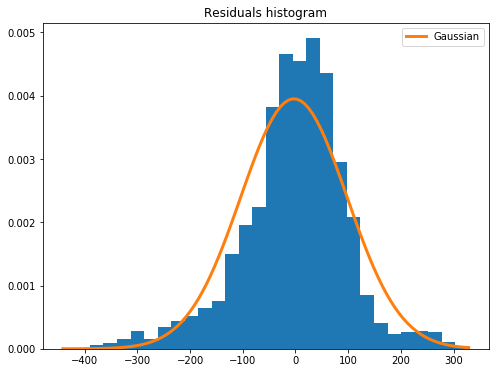

In [9]:
func.plot_residuals_hist(df_pred)

### b. Residuals of the logarithm of the target variable

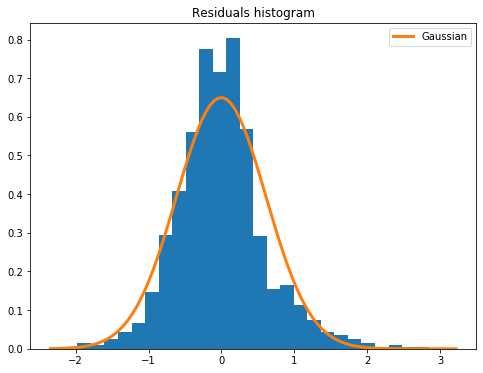

In [10]:
func.plot_residuals_hist(np.log(df_pred_logY))

## 7. Score the simple model
- Stability of the model can be measured by looking at the mean and standard deviation of e.g. the r2-score in cross-validation, which is based on five folds of the training data
- Meaningful scores are measured based on the re-transformed target y-variable, i.e. Test rSq, Test rmSqE and Test mSqLE

### a. Calculate cross-validation scores for log(y) vs. x

In [11]:
func.print_cross_val_results(m_lr_logY, X_train_fe, np.log(y_train))

        rSq  mean rSq   std rSq     mSqLE    rmSqLE
0  0.817535  0.822376  0.008542  0.407035  0.637993
1  0.828787  0.822376  0.008542  0.380568  0.616902
2  0.808223  0.822376  0.008542  0.398473  0.631247
3  0.825437  0.822376  0.008542  0.388379  0.623201
4  0.831896  0.822376  0.008542  0.394639  0.628203


### b. Calculate scores for y vs. x

In [12]:
func.print_logmodel_scores(m_lr_logY, X_train_fe, X_test_fe, y_train, y_test)

   Train rSq  Test rSq  Train rmSqE  Test rmSqE  Train mSqLE  Test mSqLE
0   0.711458  0.709747     97.29715   97.592873     0.342995    0.335562


## 7. Generate time series plots as a diagnostic tool for upper-bound model performance
Plotting the entire predicted and actual time series of the bike rental counts reveals the strengths and weaknesses of the model. To show the entire time series, a new simple model is trained on the entire training set. Predictions are made on the same training data. Note that this plot does not show objective model performance, as the model predicts on the same data used to fit the model. However, plotting the entire time series in this way reveals an upper bound to the model performance as a diagnostic tool.

### Observed strengths of the simple model:
- The seasonal and yearly trends are well-approximated
- Generally speaking, the days of the week are accurately separated. In the very early morning the predicted bike count is almost always zero, reflecting the actual rentals
- The timing of the rush hour peaks on weekdays are well-approximated


### Observed weaknesses of the simple model:
- The model is on average biased towards fewer than actual bike rentals as can be seen in the seasonal plot
- The model does not predict the size of the rush hour peaks well. In particular the first peak in the morning is significantly lower than actuals
- The model does not differentiate between weekdays and weekends. The weekday pattern of rentals is falsely applied to weekends as well, which peak at approximately 1 pm

(<Figure size 1152x760.32 with 2 Axes>, <Figure size 1152x760.32 with 4 Axes>)

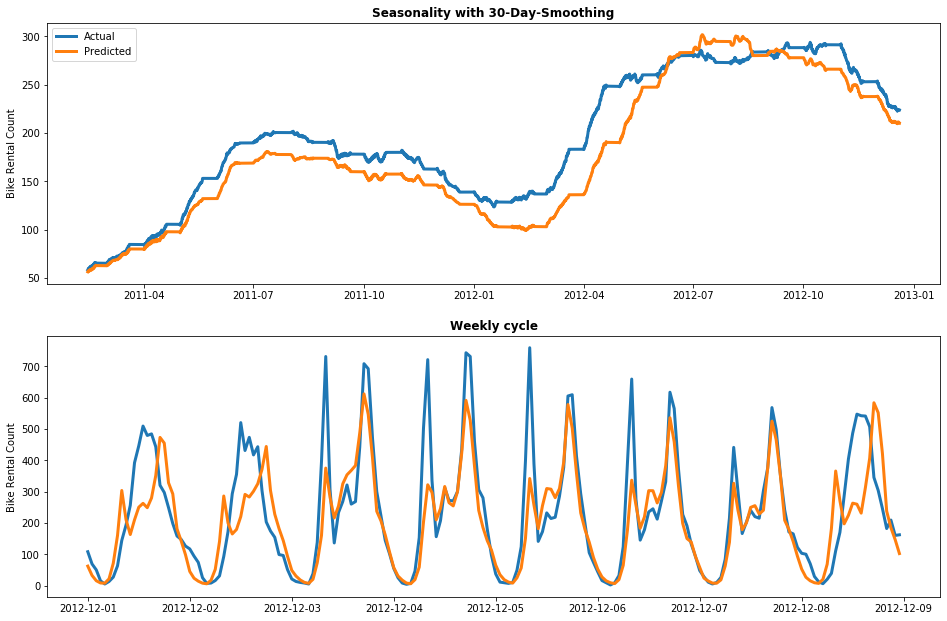

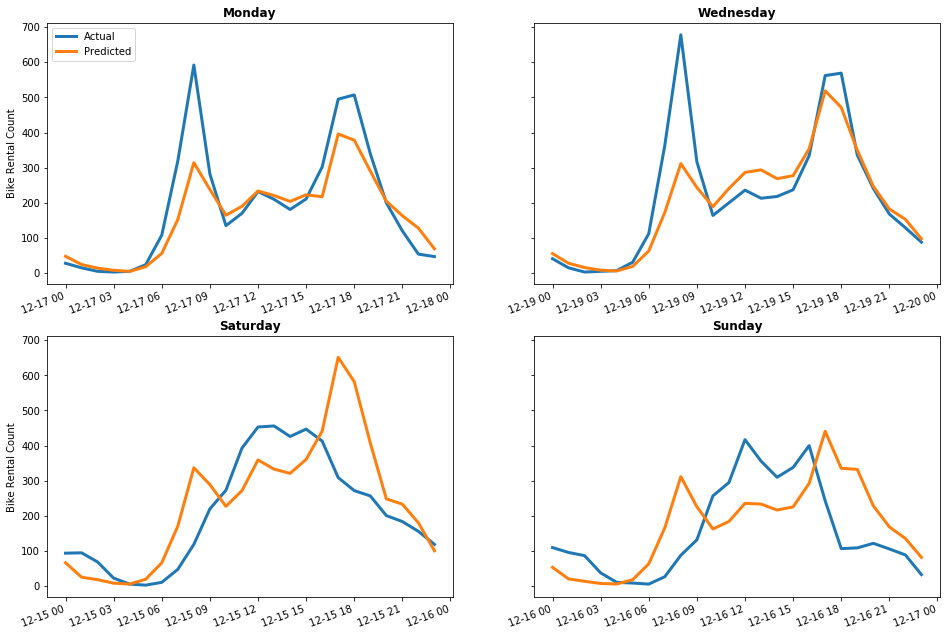

In [13]:
model = LinearRegression()
data_fe = func.feature_engineer_baseline(data)
fitted_model = model.fit(data_fe, np.log(y))

df_pred = func.create_predictions(fitted_model, data_fe, y)
func.plot_diagnostics_timescales(df_pred)

## 9. Intermediate conclusions and next steps
- The simple model serves as a good first approximation of the bike rental count, significantly reducing the RMSE from ca. 182 bikes (mean dummy classifier) to ca. 97 bikes. The model reproduces the general variability patterns across all time-scales well. This is reflected in an R2-score of ca. 71 % compared to zero for the dummy classifier, which by construction predicts a constant value
- Failures to reproduce the size of the rush hour peaks and to differentiate weekday from weekend patterns point towards promising next steps: include non-linear interaction terms in the model! 
    - The dayOfWeek feature does not efficiently separate working day and weekend patterns and should be replaced by a more efficient predictor

## 10. Feature engineer a second model including a single key interaction term
- Improving on the first model is to improve the first rush-hour peak during working days, and to separate working days from weekends and holidays
- One way is to add an interaction term to our model: the 8hr binary feature multiplied by the workingday binary feature:
    - new_feature: hr_8_workingday
- hr_8_workingday includes a morning rush hour on working days only, because on weekends and holidays this feature will be zero
- hr_8_workingday should serve to better predict the size of the rush hour peak during working days, and to remove it from the weekend pattern
    - This new feature should also make the dayOfWeek feature obsolete

### Columns of the second model:

['yr_2012', 'mon_2', 'mon_3', 'mon_4', 'mon_5', 'mon_6', 'mon_7',
       'mon_8', 'mon_9', 'mon_10', 'mon_11', 'mon_12', 'hr_1', 'hr_2', 'hr_3',
       'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'humidity', 'windspeed', 'atemp',
       'weather', 'workingday', 'hr_8_workingday']

In [14]:
print('3. Feature Engineering...\n')
X_train_fe = func.feature_engineer_single_interaction_term(X_train)
X_test_fe = func.feature_engineer_single_interaction_term(X_test)

3. Feature Engineering...



## 11. Train second model

In [15]:
print('5. Modeling...\n')
m_lr_logY = LinearRegression()
m_lr_logY.fit(X_train_fe, np.log(y_train))

5. Modeling...



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 12. Score second model
- Stability of the model can be measured by looking at the mean and standard deviation of e.g. the r2-score in cross-validation, which is based on five folds of the training data. 
- Meaningful scores are measured based on the re-transformed target y-variable, i.e. Test rSq and Test mSqLE

### a. Calculate cross-validation scores for log(y) vs. x

In [16]:
func.print_cross_val_results(m_lr_logY, X_train_fe, np.log(y_train))

        rSq  mean rSq   std rSq     mSqLE    rmSqLE
0  0.831810  0.831052  0.006815  0.375192  0.612529
1  0.836495  0.831052  0.006815  0.363435  0.602856
2  0.818092  0.831052  0.006815  0.377967  0.614790
3  0.832065  0.831052  0.006815  0.373634  0.611256
4  0.836800  0.831052  0.006815  0.383125  0.618971


### b. Calculate scores for y vs. x

In [17]:
func.print_logmodel_scores(m_lr_logY, X_train_fe, X_test_fe, y_train, y_test)

   Train rSq  Test rSq  Train rmSqE  Test rmSqE  Train mSqLE  Test mSqLE
0   0.769677  0.760422    86.928816   88.665247     0.323519    0.315614


## 13. Plot second model
### Observed strengths
- From the plots below we can observe that the size of the 8hr peak on working days is more accurately predicted. This makes sense, because this model has the sophistication to differentiate an 8am working day rush hour from a lazy Saturday or Sunday morning 
- At the same time, our weekend patterns have improved dramatically, representing a broader singular peak during the day
- The general negative bias of the model has somewhat decreased

### Observed weaknesses
- Six o'clock rush hour and other hours of the day are still influencing the weekend patterns
- The predicted weekend bike counts do not reflect the same smoothness of the actuals


(<Figure size 1152x760.32 with 2 Axes>, <Figure size 1152x760.32 with 4 Axes>)

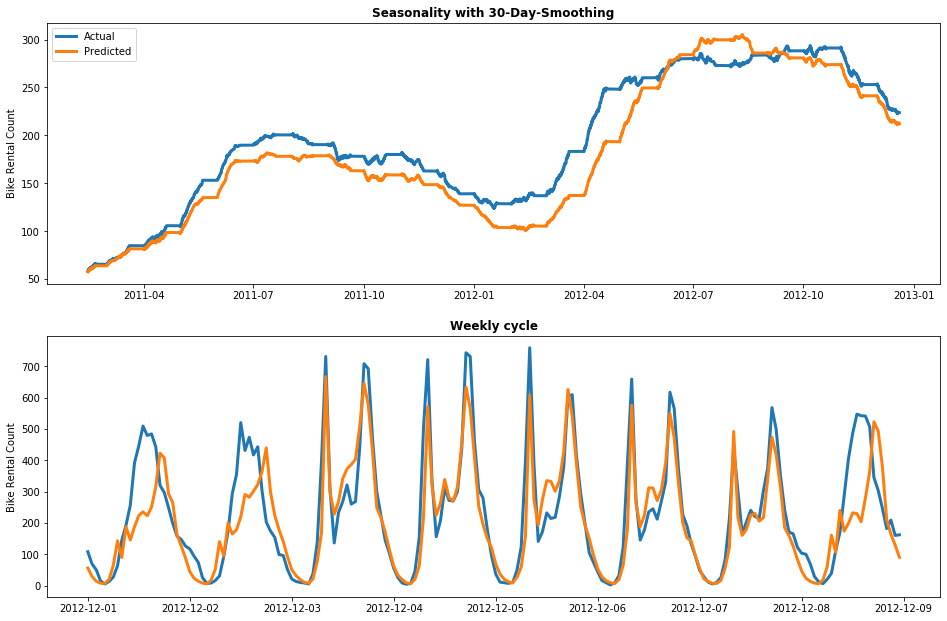

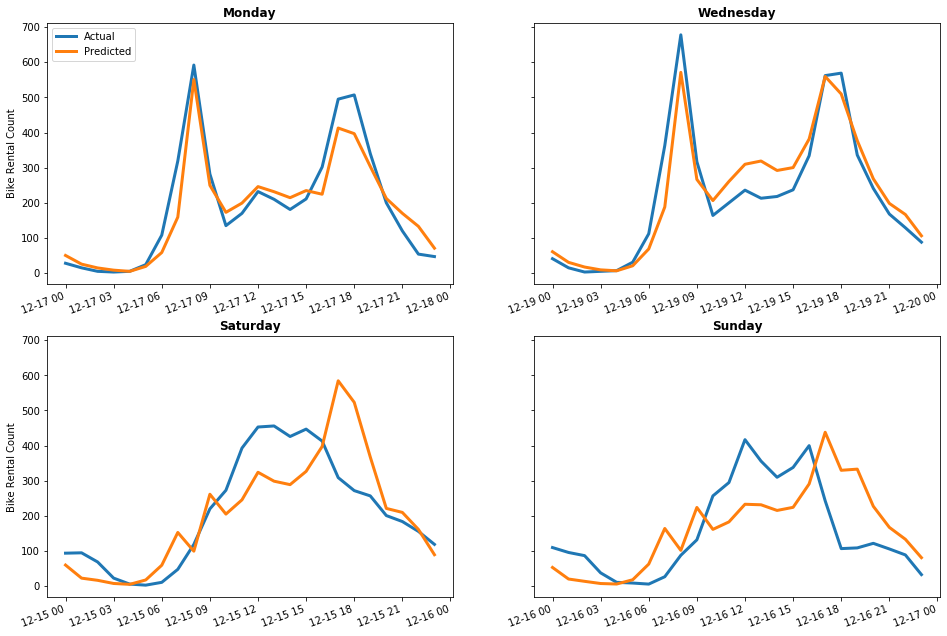

In [18]:
model = LinearRegression()
data_fe = func.feature_engineer_single_interaction_term(data)
fitted_model = model.fit(data_fe, np.log(y))

df_pred = func.create_predictions(fitted_model, data_fe, y)
func.plot_diagnostics_timescales(df_pred)

## 14. Conclusions from the second model and next steps
- The second model has greatly improved over the first model through addition of a singular key interaction term
- The morning rush hour is better represented on working days, and is no longer predicted on weekends
- The RMSE of the second model is ca. 89 bikes compared to 97 bikes in the first model
- The R2-score has improved to 76 % in the second model, a 5% increase from the first model
- Next steps: 
    - include more interaction terms for more hours of the day 
    - include radial-based functions to smoothen out irregular peaks on weekends

## 15. Feature engineer a third model including more interaction terms and radial base functions (RBFs)
- So far the second model does a decent job predicting working days, but not so much weekend days and holidays
- Including more interaction terms between hours of the day and working days (or non-working days) can help the model to differentiate the working days from the weekend
- Adding 22 more interaction terms for each hour of the day can be useful, but bears the risk of correlation among features
- I will experiment with radial base functions to limit the number of additional features and smoothen out irregular peaks

The Radial Base Function (RBF) uses a continuous distribution to encode ordinal features. You can think of the RBF as a deluxe one-hot encoding. For each hour of the day, instead of applying a binary variable, the continuous distribution will peak at the desired hour and have a fixed pre-defined variance. As can be seen in data preparation (step 2), the following function produces the RBFs: 

- func.rbf_transform(data, 24, 4). This function produces 24 normal distributions per each day of the dataset, one for each hour of the day. Each distribution has a variance of 4 hours. 


### Columns of the third model:

['yr_2012', 'mon_2', 'mon_3', 'mon_4', 'mon_5', 'mon_6', 'mon_7',
       'mon_8', 'mon_9', 'mon_10', 'mon_11', 'mon_12', 'hr_1', 'hr_2', 'hr_3',
       'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'humidity', 'windspeed', 'atemp',
       'weather', 'hr_1_weekendHol_rbf', 'hr_8_weekendHol_rbf',
       'hr_13_weekendHol_rbf', 'hr_18_weekendHol_rbf', 'hr_21_weekendHol_rbf']

In [19]:
print('3. Feature Engineering...\n')
X_train_fe = func.feature_engineer_rbf(X_train)
X_test_fe = func.feature_engineer_rbf(X_test)

3. Feature Engineering...



## 16. Train third model

In [20]:
print('5. Modeling...\n')
m_lr_logY = LinearRegression()
m_lr_logY.fit(X_train_fe, np.log(y_train))

5. Modeling...



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 17. Score third model

### a. Calculate cross-validation scores for log(y) vs. x

In [21]:
func.print_cross_val_results(m_lr_logY, X_train_fe, np.log(y_train))

        rSq  mean rSq   std rSq     mSqLE    rmSqLE
0  0.827034  0.829118  0.006808  0.385845  0.621164
1  0.836385  0.829118  0.006808  0.363680  0.603059
2  0.816941  0.829118  0.006808  0.380359  0.616732
3  0.831655  0.829118  0.006808  0.374546  0.612001
4  0.833577  0.829118  0.006808  0.390693  0.625054


### a. Calculate scores for y vs. x

In [22]:
func.print_logmodel_scores(m_lr_logY, X_train_fe, X_test_fe, y_train, y_test)

   Train rSq  Test rSq  Train rmSqE  Test rmSqE  Train mSqLE  Test mSqLE
0   0.759211  0.761523    88.882063    88.46124     0.327883    0.320918


## 18. Plot third model
### Observed strengths
- Predicted bike rentals on weekend days represent the actuals much better than the second model does

### Observed weaknesses
- Predicted bike rentals on week days have deteriorated. In particular the morning rush hour peak is no longer well-represented
- Overall model scores have marginally improved compared to the second model, even though there are more working days than weekend days and holidays
- The RMSE is ca. 88 bikes and the R2-score is 76 %. Note that the third model includes 4 more interaction terms than the second model



(<Figure size 1152x760.32 with 2 Axes>, <Figure size 1152x760.32 with 4 Axes>)

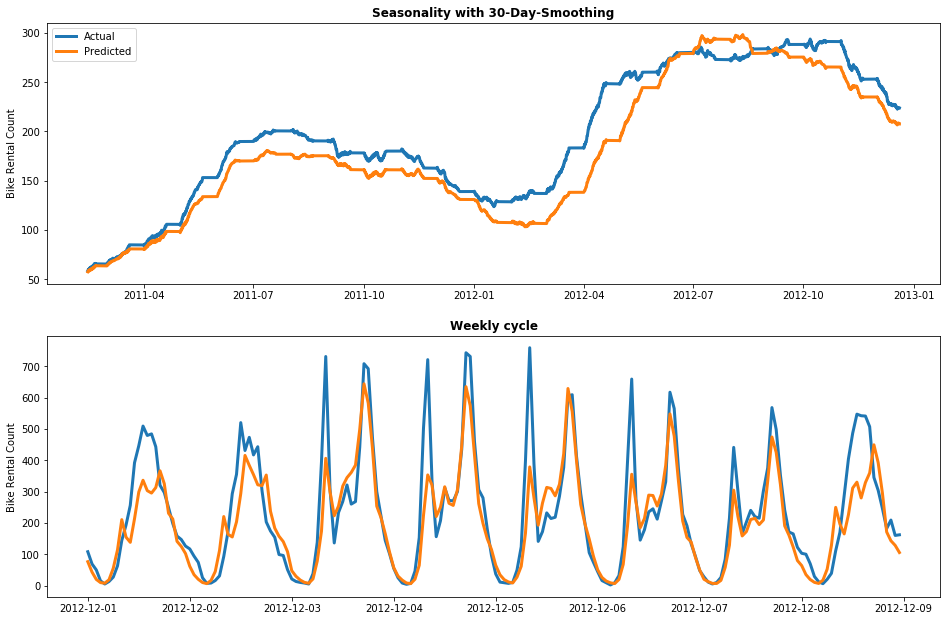

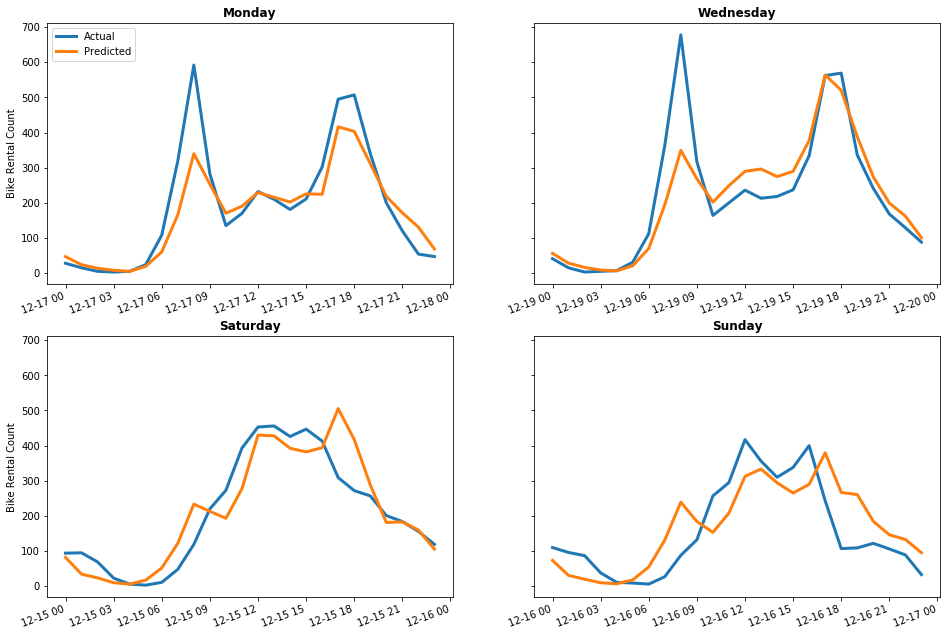

In [23]:
model = LinearRegression()
data_fe = func.feature_engineer_rbf(data)
fitted_model = model.fit(data_fe, np.log(y))

df_pred = func.create_predictions(fitted_model, data_fe, y)
func.plot_diagnostics_timescales(df_pred)

## 19. Conclusions from the third model and next steps
- The additional four more interaction terms based on RBFs have improved the overall model score only marginally
- The third model performs better on weekends, the second model better on working days
- Including interaction terms from both models into one single model is tricky however: the features based on interaction terms of both models are highly (negatively) correlated with each other. It is bad modelling practice to include them in the same model
- This points towards the next steps: 
    - the most promising approach is to train two separate models: one for weekend days and holidays and one for working days
    - this new approach goes beyond the scope of this analysis
    - the fastest route to an improved score is to focus on working days, which represent the majority of days in the year
    - next goal: score a new model trained on more interaction terms than in the second model, focusing only on improving working day predictions

## 20. Feature engineer a fourth and final model
- The goal of this model is to improve the prediction score based on the insights we have gained so far 
- This is to focus on improving the model score on working days by including more interaction terms compared to the second model
- I have also included three additional second order terms of the weather variables
    - In particular weather and humidity have "inverted U-shapes" with respect to bike count and might be better approximated with a second order term
    - The temperature variable shows a non-linear ceiling at large temperatures with respect to bike count 
- The feature engineering function now scales and centers numerical weather variables (i.e. creates z-scores for each variable)
    - To avoid multicollinearity of second-order terms in feature engineering
    - To be able to compare linear regression coefficients for variable importance


### Columns of the final model:

['yr_2012', 'mon_2', 'mon_3', 'mon_4', 'mon_5', 'mon_6', 'mon_7',
       'mon_8', 'mon_9', 'mon_10', 'mon_11', 'mon_12', 'hr_1', 'hr_2', 'hr_3',
       'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11',
       'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19',
       'hr_20', 'hr_21', 'hr_22', 'hr_23', 'humidity', 'windspeed', 'atemp',
       'weather', 'hr_8_workingday', 'hr_18_workingday', 'hr_13_workingday',
       'hr_15_workingday', 'hr_21_workingday', 'hr_1_workingday',
       'hr_14_workingday', 'hr_16_workingday', 'windspeed_Sq', 'humidity_Sq',
       'atemp_Sq']

In [24]:
print('3. Feature Engineering...\n')

scaler_weatherFeatures = StandardScaler()
scaler_allFeatures = StandardScaler()

X_train_fe, scaler_weatherFeatures, scaler_allFeatures = func.feature_engineer(X_train, scaler_weatherFeatures, scaler_allFeatures, kind = "train")
X_test_fe, scaler_weatherFeatures, scaler_allFeatures = func.feature_engineer(X_test, scaler_weatherFeatures, scaler_allFeatures, kind = "test")

3. Feature Engineering...



## 21. Train final model

In [25]:
print('5. Modeling...\n')
m_lr_logY = LinearRegression()
m_lr_logY.fit(X_train_fe, np.log(y_train))

5. Modeling...



LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## 22. Score final model

### a. Calculate cross-validation scores for log(y) vs. x

In [26]:
func.print_cross_val_results(m_lr_logY, X_train_fe, np.log(y_train))

        rSq  mean rSq   std rSq     mSqLE    rmSqLE
0  0.853147   0.85303  0.006565  0.327594  0.572358
1  0.858706   0.85303  0.006565  0.314065  0.560415
2  0.840408   0.85303  0.006565  0.331598  0.575846
3  0.857006   0.85303  0.006565  0.318144  0.564042
4  0.855883   0.85303  0.006565  0.338326  0.581658


### b. Calculate scores for y vs. x

In [27]:
func.print_logmodel_scores(m_lr_logY, X_train_fe, X_test_fe, y_train, y_test)

   Train rSq  Test rSq  Train rmSqE  Test rmSqE  Train mSqLE  Test mSqLE
0   0.833637  0.824372    73.879543     75.9149     0.277703    0.265179


## 23. Check variance inflation factors
- Variance inflation factors are all below 5. Values larger than 5 indicate high levels of multicollinearity

In [28]:
X_train_fe_vif = add_constant(X_train_fe)
pd.Series([variance_inflation_factor(X_train_fe_vif.values, i)
           for i in range(X_train_fe_vif.shape[1])],
          index=X_train_fe_vif.columns)

const               1.000000
windspeed           1.347260
humidity            2.022865
atemp               4.913712
yr_2012             1.038408
mon_2               1.955764
mon_3               2.263470
mon_4               2.606246
mon_5               3.193578
mon_6               3.747056
mon_7               4.588762
mon_8               4.215097
mon_9               3.491836
mon_10              2.969821
mon_11              2.292213
mon_12              2.179487
hr_1                4.039631
hr_2                1.906148
hr_3                1.863879
hr_4                1.895897
hr_5                1.911571
hr_6                1.907535
hr_7                1.894525
hr_8                4.056334
hr_9                1.888263
hr_10               1.917877
hr_11               1.916552
hr_12               1.961435
hr_13               3.915527
hr_14               4.053506
hr_15               4.241087
hr_16               4.167851
hr_17               2.032858
hr_18               3.948099
hr_19         

## 24. Check coefficients
- Features haven been standard scaled before applying the linear regression, allowing for a comparison of coefficients
- Coefficient size indicates variable importance 
- Note that sklearn does not give the coefficient's p-values to determine statistical significance. In this case statsmodels would be a preferred package to use

### Order of importance:
The order of importance broadly reflects the improvements in the RMSE score throughout this analysis.
- The hour of the day generally contributes most to the model
- These are followed by a few key interaction terms such as hr_8_workingday
- Followed by variables year, month, and further interaction terms
- Finally weather variables and their second order terms come last
- Transformations of weather variables could improve their predictive power

In [29]:
coefficients = pd.DataFrame()

coefficients['variables'] = X_train_fe.columns
coefficients['coefficients'] = m_lr_logY.coef_
coefficients['absoluteCoeff'] = np.absolute(coefficients['coefficients'])
coefficients['intercept'] = m_lr_logY.intercept_

coefficients.sort_values("absoluteCoeff", ascending = False)

,variables,coefficients,absoluteCoeff,intercept
31,hr_17,0.446427,0.446427,4.548721
27,hr_13,0.403252,0.403252,4.548721
30,hr_16,0.402233,0.402233,4.548721
28,hr_14,0.401369,0.401369,4.548721
29,hr_15,0.400196,0.400196,4.548721
18,hr_4,-0.399212,0.399212,4.548721
33,hr_19,0.366582,0.366582,4.548721
32,hr_18,0.358764,0.358764,4.548721
17,hr_3,-0.341295,0.341295,4.548721
23,hr_9,0.318644,0.318644,4.548721


## 25. Conclusions from the final model
- The RMSE and R2-scores have been further improved, which are 76 bikes and 82 % respectively
- The variance inflation factors are all below 5, an acceptable tolerance level for multicollinearity of predictors 
- Time features play the largest role, weather variables the least important role
- Cross-validation indicates stable scores, i.e. a model with low variance
- Other transformations of weather variables could improve their predictive power

## 26. Summary
- I trained a dummy classifier on the bike rental demand data which gives an RMSE of ca. 181 bikes
- I have successively improved the RMSE and R2-scores with each new model based on new insights
- The final RMSE and R2-scores are ca. 76 bikes and 82 % respectively, a major improvement over the dummy classifier
- The final model performs weaker on weekend days
- Although machine learning models other than linear regression might be more suitable for this problem, using linear regression has proven a valuable lesson to understand the strengths and weaknesses of a linear model:
    - linear models allow for a good understanding of the relationship between predictors and target variables
    - non-linear interactions can be explicitly modelled, further allowing for a good understanding of non-linear behaviours
    
### Further areas of improvement
- Training separate models for working days and weekends/holidays is a promising approach to further improve predictions
- Linear regression makes a few strong assumptions which have not been checked in this analysis. Please see the notebook linear_regression_assumptions for an analysis
    - In summary, residuals are non-normally distributed, slightly biased (as already observed here), and heteroscedastic particularly in the weather variables
- A lasso regression is a promising approach to reduce the number of features in the model
- The residuals plot of the linear regression assumptions analysis suggests a transformation of some of the weather variables, which are not being modelled efficiently
- The month features are correlated with weather features, because they inherently contain weather information, i.e. June is warmer and dryer than January and a more attractive month for biking
    - It might be more promising to look at weather variables as deviations from their monthly average to separate them from seasonality already reflected in the months
